## 1. Introduction
In natural language processing, the Latent Dirichlet Allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.
We would like to determine the number of topics on tweets from Egypt collected in 1st Decemeber 2022.

## 2. Exploratory data analysis (EDA)

### 2.1 Initialize Spark

In [20]:
! pip install findspark
! pip install pyspark

import json 
import findspark
findspark.find()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'/usr/local/lib/python3.8/dist-packages/pyspark'

### 2.2 Create the spark app 

In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode, udf, lit, col, size, expr

spark = SparkSession.builder.appName('read JSON files').getOrCreate()

### 2.3 Read all the fetched tweets Json files

In [22]:
json_df = spark.read.option("multiline", "true").json(
    "/content/drive/MyDrive/DecTweets/WCTweets.json")

for i in range(2, 100):
    path = "/content/drive/MyDrive/DecTweets/WCTweets"+str(i)+".json"
    print(path)
    temp_df = spark.read.option("multiline", "true").json(path=path)
    json_df = json_df.unionByName(temp_df, allowMissingColumns=True)
    json_df.count()
    temp_df=None

/content/drive/MyDrive/DecTweets/WCTweets2.json
/content/drive/MyDrive/DecTweets/WCTweets3.json
/content/drive/MyDrive/DecTweets/WCTweets4.json
/content/drive/MyDrive/DecTweets/WCTweets5.json
/content/drive/MyDrive/DecTweets/WCTweets6.json
/content/drive/MyDrive/DecTweets/WCTweets7.json
/content/drive/MyDrive/DecTweets/WCTweets8.json
/content/drive/MyDrive/DecTweets/WCTweets9.json
/content/drive/MyDrive/DecTweets/WCTweets10.json
/content/drive/MyDrive/DecTweets/WCTweets11.json
/content/drive/MyDrive/DecTweets/WCTweets12.json
/content/drive/MyDrive/DecTweets/WCTweets13.json
/content/drive/MyDrive/DecTweets/WCTweets14.json
/content/drive/MyDrive/DecTweets/WCTweets15.json
/content/drive/MyDrive/DecTweets/WCTweets16.json
/content/drive/MyDrive/DecTweets/WCTweets17.json
/content/drive/MyDrive/DecTweets/WCTweets18.json
/content/drive/MyDrive/DecTweets/WCTweets19.json
/content/drive/MyDrive/DecTweets/WCTweets20.json
/content/drive/MyDrive/DecTweets/WCTweets21.json
/content/drive/MyDrive/DecTw

### 2.4 Create a new dataframe ***data_df*** that contains only the data attribute of each tweet

In [24]:
# Select the data column from the json_df, and adds a new column to the data_df called "data"
# that column has an alias called "data", and each row has the data of only one objects.
data_df=json_df.select('data').withColumn('data', explode('data').alias('data'))

#### 2.4.1 Selecting only the inner attributes of the ***data*** attribute 

In [25]:
data_df = data_df.select('data.author_id',
                         'data.created_at',
                         'data.geo.place_id',
                         'data.id',
                         'data.public_metrics',
                         'data.text')

### 2.5 Create a new dataframe ***place_df*** that contains only the *includes.places* attribute of each tweet

In [26]:
# select the place content
place_df=json_df.select('includes.places')

### 2.6 Create a new dataframe ***user_df*** that contains only the *includes.users* attribute of each tweet

In [27]:
# select the user content
user_df=json_df.select('includes.users')

In [28]:
user_df.printSchema()

root
 |-- users: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- location: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- username: string (nullable = true)
 |    |    |-- withheld: struct (nullable = true)
 |    |    |    |-- country_codes: array (nullable = true)
 |    |    |    |    |-- element: string (containsNull = true)



### 2.7 Unravel the nested json

In [29]:
import pyspark.sql.types as T
from pyspark.sql.functions import col


#### 2.7.1 Define a function to read the nested json structure

In [30]:
def read_nested_json(df):
    column_list = []
    # Iterate over all the column names in the schema
    for column_name in df.schema.names:
        # Check if the column is of "ArrayType"
        if isinstance(df.schema[column_name].dataType, T.ArrayType):
            # Replace the column of "ArrayType" with an exploded version of that column
            df = df.withColumn(column_name, explode(column_name).alias(column_name))
            # Append the column name to an array of column list array
            column_list.append(column_name)

        # Check if the column is of "StructType"
        elif isinstance(df.schema[column_name].dataType, T.StructType):
            # Iterate over all fields of this struct
            for field in df.schema[column_name].dataType.fields:
                # Append a new column made of the column name and the field name to the column list array 
                column_list.append(col(column_name + "." + field.name).alias(column_name + "_" + field.name))
        
        # If the column is neither an "ArrayType" nor a "StructType" aka "Leaf" attribute
        # eg:"String" , "Long", etc.
        # add this column to the column list array
        else:
            column_list.append(column_name)

    # Selecting columns using column_list from dataframe: df
    df = df.select(column_list)
    return df

#### 2.7.2 Define a function to flatten the nested JSON File

In [31]:
# This is a recursive function to allow the flattening 
# of nested "ArrayTypes" or "StructTypes" 
def flatten_nested_json(df):
    read_nested_json_flag = True
    while read_nested_json_flag:
        df = read_nested_json(df)
        read_nested_json_flag = False
        
        # Check if there is still an "ArrayType" or "StructType" after the 
        # reading itertaion and if there is, iterate over the json 
        # structure again until there are no "ArrayType" or "StructType" 
        # in the dataframe, only primitive types.
        for column_name in df.schema.names:
            if isinstance(df.schema[column_name].dataType, T.ArrayType):
              read_nested_json_flag = True
            elif isinstance(df.schema[column_name].dataType, T.StructType):
              read_nested_json_flag = True
    return df

#### 2.7.3 Flatten the Data df 

In [32]:
data_df=flatten_nested_json(data_df)

#### 2.7.4 Perform different sql queries on the data dataframe

In [33]:
# change dataframe name
data_df.createOrReplaceTempView("df_data")

#### 2.7.5 Flatten the Place df 

In [34]:
place_df=flatten_nested_json(place_df)

#### 2.7.6 Perform different sql queries on the dataframe 

In [35]:
# change the name of place_df dataframe
place_df.createOrReplaceTempView("df_place")

#### 2.7.7 Flatten the Users df

In [36]:
# flatten the neseted json of user
user_df=flatten_nested_json(user_df)

#### 2.7.8 Perform different sql queries on the dataframe to learn more information 

In [37]:
# change the name of user_df dataframe
user_df.createOrReplaceTempView("df_user")

## 3. Topic Modeling

### 3.1 Importing Libs

In [38]:
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from gensim.models import LsiModel


###  3.2 Create a new dataframe that contains only the tweet id, creation date and text

In [39]:
tweet_text = data_df.select('id','created_at','text')

### 3.3 Data Preprocessing and Cleaning

#### 3.3.1 Importing Libs

In [40]:
# Preprocess steps
import re
from pyspark.sql.functions import to_timestamp
import pyspark.sql.types as T


#### 3.3.2 Change the *created_at* attribute from **String** to **DateType**

In [41]:
tweet_text=tweet_text.withColumn("created_date", tweet_text['created_at'].cast(T.DateType()))

#### 3.3.3 Define the UDFs for the cleaning process

In [90]:
PUNCTUATION = '!"$%&\'()*+,-./:;<=>?[\]^_`{|}~•@â'

def removeLinks(tweet):
    tweet = re.sub(r'http\S+', '', tweet) 
    tweet = re.sub(r'bit.ly/\S+', '', tweet) 
    tweet = tweet.strip('[link]') 
    return tweet
def removeMentions(tweet):
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    return tweet
def removePunctuation(tweet):
    tweet = re.sub('['+ PUNCTUATION + ']+', ' ', tweet) 
    return tweet
def removeNumbers(tweet):
    tweet = re.sub('([0-9]+)', '', tweet) 
    return tweet

def removeBreakLines(tweet):
    tweet=tweet.strip().replace('\n', '')
    tweet=tweet.strip().replace('\r', '')
    tweet = tweet.strip().replace('\t', '')
    return tweet


def remove_emoji(tweet):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251""]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)

In [91]:
# register user defined function
removeLinks = udf(removeLinks)
removeMentions = udf(removeMentions)
removePunctuation=udf(removePunctuation)
removeNumbers=udf(removeNumbers)
removeBreakLines= udf(removeBreakLines)
remove_emoji=udf(remove_emoji)

#### 3.3.4 Remove Links, User Mentions, Punctuation and Numbers from *tweet_text*

In [44]:
tweet_text=tweet_text.withColumn('cleaned_Text', removeLinks(tweet_text['text']))

In [45]:
tweet_text=tweet_text.withColumn('cleaned_Text', removeMentions(tweet_text['cleaned_Text']))

In [46]:
tweet_text=tweet_text.withColumn('cleaned_Text', removePunctuation(tweet_text['cleaned_Text']))

In [47]:
tweet_text=tweet_text.withColumn('cleaned_Text', removeNumbers(tweet_text['cleaned_Text']))

In [92]:
tweet_text=tweet_text.withColumn('cleaned_Text', removeBreakLines(tweet_text['cleaned_Text']))

In [93]:
tweet_text=tweet_text.withColumn('cleaned_Text', remove_emoji(tweet_text['cleaned_Text']))

##### 3.3.4.1 Display 10 original tweets and their corresponding cleaned text

In [94]:
tweet_text.select('text','cleaned_Text').show(10)

+--------------------+--------------------+
|                text|        cleaned_Text|
+--------------------+--------------------+
|RT @GodhariTarak:...|The moment messi ...|
|RT @AliciaMimundo...|¡¡¡Enhorabuena #A...|
|RT @achopkins1: T...|The Turkish presi...|
|WORLD CUP FINALS:...|WORLD CUP FINALS ...|
|RT @ManUtd: On to...|On top of the wor...|
|RT @Bob_cart124: ...|If Messi had worn...|
|RT @AliHZaidiPTI:...|Memorable game of...|
|RT @ComedianSirLa...|Who s The GOAT RT...|
|RT @Omid_M: He lo...|He loved #Argenti...|
|RT @577_ah: لقطة ...|RT   ah  لقطة ختا...|
+--------------------+--------------------+
only showing top 10 rows



#### 3.3.5 Create a tokenizer 

In [49]:
# A tokenizer that matches any tokens that contains characters,
# with a minimum length of 3 characters, from the cleaned_Text,
# and output the tokens in the tokens output.

tokenizer = RegexTokenizer().setPattern("[\\W_]+").setMinTokenLength(3).setInputCol("cleaned_Text").setOutputCol("tokens")

In [50]:
tokenized_tweets = tokenizer.transform(tweet_text)

#### 3.3.6 Create a WordNet Lemmatizer

In [51]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


##### 3.6.6.1 Create a lemmatizing function

In [52]:
# Defining Lemmatizing function that takes each row 
# and lemmatize each word to a verb and return the 
# row containing the lemmatized words.

def lemmatization(row):
    row = [lemmatizer.lemmatize(word,'v') for word in row]
    return row


lemmatize = udf(lemmatization)

##### 3.6.6.2 Create a new column that contains the lemmatized tokens

In [53]:

tokenized_tweets=tokenized_tweets.withColumn('tokens_lemma', lemmatize(tokenized_tweets['tokens']))

#### 3.3.7 Removing Stop words

In [56]:
twitter_stopwords = open('/content/drive/MyDrive/TwitterStopWords.txt.html', 'r').read().split(",")

In [57]:
# Create a new stopwords list from twitter stop list and the nltk wordnet list
stopwordList=StopWordsRemover().getStopWords()
stopwordList.extend(twitter_stopwords)
stopwordList = list(set(stopwordList))

In [58]:
# Create a new stopWordsRemover with the stopwords as our 
# extended stopwordsList, the input from the tokens column,
# and output to cleaned_tokens column.
remover = StopWordsRemover(stopWords=stopwordList).setInputCol("tokens").setOutputCol("cleaned_tokens")

In [59]:
cleaned_tweets = remover.transform(tokenized_tweets)

### 3.4 Latent Dirichlet Allocation (LDA)

In [60]:
# create a vector of words that at least appeared in two different tweets, and set maximum vocab size to 20000.
vectorizer = CountVectorizer().setInputCol("cleaned_tokens").setOutputCol("features").setVocabSize(20000).setMinDF(2).fit(cleaned_tweets)
wordVectors = vectorizer.transform(cleaned_tweets)

In [61]:
# set number of topic
# set the mertic to evaluate model performance
num_topics = range(2, 11)
models = []
log_likeli = []
log_perp = []
for num in num_topics:
    # LDA
    # create Latent Dirichlet Allocation model and run it on our data with 50 iteration and selected topics number
    lda = LDA(k=num, maxIter=50)
    # fit the model on data
    ldaModel = lda.fit(wordVectors)
    models.append(ldaModel)
    ll = ldaModel.logLikelihood(wordVectors)
    lp = ldaModel.logPerplexity(wordVectors)
    log_likeli.append(ll)
    log_perp.append(lp)


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
plot_data=pd.DataFrame(list(zip(num_topics,log_likeli,log_perp)),
            columns=['topics_num','logLikelihood','logPerplexity'])

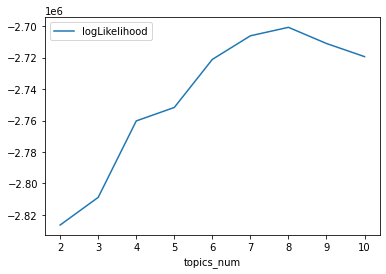

In [63]:
# use the elbow method to determine the optimal k
plot_data.plot(x='topics_num', y='logLikelihood', kind='line')
plt.show()

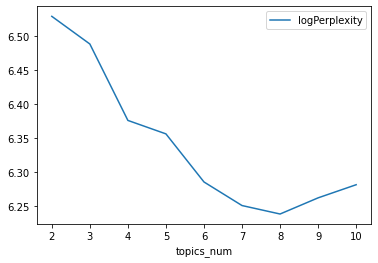

In [64]:
# use the elbow method to determine the optimal k
plot_data.plot(x='topics_num', y='logPerplexity', kind='line')
plt.show()

In [65]:
model=models[2]

In [66]:
# LDA
# create Latent Dirichlet Allocation model and run it on our data with 50 iteration and selected topics number
lda = LDA(k=4, maxIter=100)
# fit the model on data
model = lda.fit(wordVectors)

In [67]:
ll = model.logLikelihood(wordVectors)
lp = model.logPerplexity(wordVectors)


In [68]:
print("The lower bound on the log likelihood of the entire corpus: ",ll)
print("The upper bound on perplexity: ",lp)

The lower bound on the log likelihood of the entire corpus:  -2740019.3497474305
The upper bound on perplexity:  6.329553376348036


In [69]:
# extract vocabulary from CountVectorizer
vocab = vectorizer.vocabulary

In [70]:
# create topics based on LDA
lda_topics = model.describeTopics()

In [71]:
topics_rdd = lda_topics.rdd
topics_words = topics_rdd\
    .map(lambda row: row['termIndices'])\
    .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
    .collect()

for idx, topic in enumerate(topics_words):
    print("topic: {}".format(idx))
    print("*"*25)
    for word in topic:
       print(word)
    print("*"*25)


topic: 0
*************************
worldcup
messi
argentina
fifaworldcup
qatar
world
argentinavsfrance
worldcupfinal
cup
fifa
*************************
topic: 1
*************************
worldcup
argentina
martinez
una
winner
lisandro
del
que
qatar
hoy
*************************
topic: 2
*************************
world
worldcup
cup
argentina
congratulations
game
best
ever
way
worldcupfinal
*************************
topic: 3
*************************
worldcup
argentina
que
partido
dios
enhorabuena
les
messi
tout
media
*************************


In [72]:
transformed = model.transform(wordVectors)

In [73]:
transformed.printSchema()

root
 |-- id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- text: string (nullable = true)
 |-- created_date: date (nullable = true)
 |-- cleaned_Text: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_lemma: string (nullable = true)
 |-- cleaned_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- topicDistribution: vector (nullable = true)



In [74]:
to_array = udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))

In [75]:
max_index = udf(lambda x: x.index(__builtin__.max(x))
                if x is not None else None, T.IntegerType())

In [76]:
topic_index = udf(lambda x: 'topic'+str(x), T.StringType())

In [77]:
key_word = udf(lambda x: ', '.join(topics_words[x]), T.StringType())

In [78]:
transformed=transformed.withColumn('topicDistribution_array', to_array(transformed['topicDistribution']))
transformed=transformed.withColumn('dominant_topic_index', max_index(transformed['topicDistribution_array']))

In [79]:
transformed=transformed.withColumn('dominant_topic', topic_index(transformed['dominant_topic_index']))

In [80]:
transformed=transformed.withColumn('dominant_topic_keywords', key_word(transformed['dominant_topic_index']))

In [81]:
transformed.groupBy("created_date","dominant_topic","dominant_topic_keywords").count().orderBy("created_date","dominant_topic").show()

+------------+--------------+-----------------------+-----+
|created_date|dominant_topic|dominant_topic_keywords|count|
+------------+--------------+-----------------------+-----+
|  2022-12-18|        topic0|   worldcup, messi, ...|28738|
|  2022-12-18|        topic1|   worldcup, argenti...| 4997|
|  2022-12-18|        topic2|   world, worldcup, ...| 7786|
|  2022-12-18|        topic3|   worldcup, argenti...| 7526|
+------------+--------------+-----------------------+-----+



In [82]:
transformed.groupBy("created_date","dominant_topic","dominant_topic_keywords").count().toPandas().to_csv('NovemberTopics.csv')

## 4. Sentiment Analysis

### 4.1 Importing Libs

In [88]:
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk

! pip install pycountry

import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer

! pip install langdetect

from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

! pip install googletrans==3.1.0a0

from googletrans import Translator

detector = Translator()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 4.2 Getting Topic from User

In [ ]:
topic = input("Enter topic to analyze sentiment over: ")

### 4.3 Fetching Tweets and Analyzing Sentiment

In [86]:
# function to compute the percentage
def percentage(part,whole):
    return 100 * float(part)/float(whole)

In [ ]:
# Authentication
consumerKey = 
consumerSecret = 
accessToken = 
accessTokenSecret = 
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

In [97]:
import nltk
nltk.download('vader_lexicon')
  

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [98]:
noOfTweets = json_df.count() # number of tweets to iterate over

positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

for tweet in tweet_text.collect():
    dec_lan = detector.detect(tweet["cleaned_Text"])

    if dec_lan.lang == "en" and dec_lan.confidence == 1:
       
    
        # print(tweet["cleaned_Text"])
        tweet_list.append(tweet["cleaned_Text"])
        analysis = TextBlob(tweet["cleaned_Text"])
        score = SentimentIntensityAnalyzer().polarity_scores(tweet["cleaned_Text"])
        neg = score['neg']
        neu = score['neu']
        pos = score['pos']
        comp = score['compound']
        polarity += analysis.sentiment.polarity
    
        if (neg > pos):
            negative_list.append(tweet["cleaned_Text"])
            negative += 1
        elif (neg < pos):
            positive_list.append(tweet["cleaned_Text"])
            positive += 1
        else:
            neutral_list.append(tweet["cleaned_Text"])
            neutral += 1
    else: continue

positive = percentage(positive, noOfTweets)
negative = percentage(negative, noOfTweets)
neutral = percentage(neutral, noOfTweets)
polarity = percentage(polarity, noOfTweets)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

In [99]:
#Number of Tweets (Total, Positive, Negative, Neutral)

tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)

print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

total number:  16988
positive number:  10521
negative number:  3173
neutral number:  3294


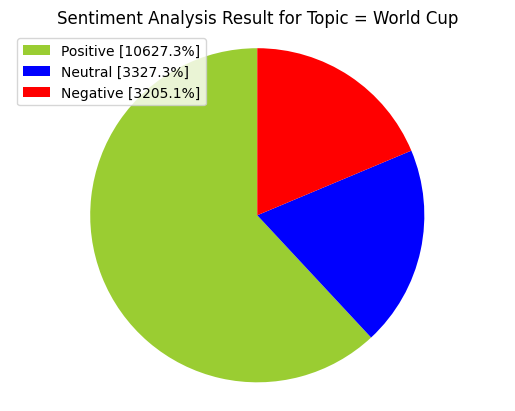

In [101]:
#Creating PieCart

labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)

plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for Topic = World Cup" )
plt.axis('equal')
plt.show()